In [144]:
import pandas as pd
import os
import folium as f
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic as gd
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Importação e limpeza dos dados

O intuito é fazer a importação dos dados para o projeto e fazer um primeiro tratamento.

### Tratamentos
- Verificar valores ausentes
- Detectar outliers em RSSI e em altitude
- Normalizar os tipos

In [145]:
if os.path.exists('../data/raw/dataset.csv'):
    print("Dataset already exists.")
else:
    print("Dataset not found. Please ensure the file is in the correct directory.")
    raise SystemExit

dataframe = pd.read_csv('../data/raw/dataset.csv')
dataframe = dataframe[['Latitude', 'Longitude', 'Altitude', 'ED RSSI']]
dataframe.columns = ['latitude', 'longitude', 'altitude', 'rssi']

print("Dataset loaded successfully.")
print("First 5 rows of the dataset:\n", dataframe.head())

na_values = dataframe.isna().sum()
print("Valores ausentes:\n", na_values)

min_value = dataframe['rssi'].min()
max_value = dataframe['rssi'].max()
print(f"Valor mínimo: {min_value}, Valor máximo: {max_value}")

q1 = dataframe['rssi'].quantile(0.25)
q3 = dataframe['rssi'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Threshold for outliers: {lower_bound} to {upper_bound}")

outlier = dataframe[(dataframe['rssi'] < lower_bound) | (dataframe['rssi'] > upper_bound)]
print("Outliers detected:\n", outlier)

Dataset already exists.
Dataset loaded successfully.
First 5 rows of the dataset:
     latitude  longitude  altitude  rssi
0 -21.776935 -43.372421     930.5   -85
1 -21.776935 -43.372421     930.5   -93
2 -21.776934 -43.372421     930.5   -99
3 -21.776940 -43.372417     931.3   -99
4 -21.776863 -43.372451     932.5   -97
Valores ausentes:
 latitude     0
longitude    0
altitude     0
rssi         0
dtype: int64
Valor mínimo: -132, Valor máximo: -74
Q1: -115.0, Q3: -95.0, IQR: 20.0, Threshold for outliers: -145.0 to -65.0
Outliers detected:
 Empty DataFrame
Columns: [latitude, longitude, altitude, rssi]
Index: []


# Classificando a qualidade do sinal para todos os pontos

Classificando os pontos, usando quantis de tamanho 1/3 da quantidade de valores

In [146]:
bad_rssi_signal = dataframe['rssi'].quantile(1/3)
good_rssi_signal = dataframe['rssi'].quantile(2/3)

bad_signal_value = 0
medium_signal_value = 1
good_signal_value = 2

def get_signal_quality(rssi):
    if rssi < bad_rssi_signal:
        return bad_signal_value
    elif rssi < good_rssi_signal:
        return medium_signal_value
    else:
        return good_signal_value

In [147]:
dataframe['signal_quality'] = dataframe['rssi'].apply(lambda x: get_signal_quality(x))

print("Signal quality assigned based on RSSI values.")
print("Bad signal threshold:", bad_rssi_signal)
print("Good signal threshold:", good_rssi_signal)
print(dataframe[['latitude', 'longitude', 'rssi', 'signal_quality']].head())

Signal quality assigned based on RSSI values.
Bad signal threshold: -113.0
Good signal threshold: -99.0
    latitude  longitude  rssi  signal_quality
0 -21.776935 -43.372421   -85               2
1 -21.776935 -43.372421   -93               2
2 -21.776934 -43.372421   -99               2
3 -21.776940 -43.372417   -99               2
4 -21.776863 -43.372451   -97               2


# Plotando mapa com os dados coletados e pre processados

In [148]:
folium_map = f.Map(location=[dataframe['latitude'].mean(), dataframe['longitude'].mean()], zoom_start=15)

for _, row in dataframe.iterrows():
    color = 'green' if row['signal_quality'] == 2 else ('yellow' if row['signal_quality'] == 1 else 'red')
    f.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,
        popup=f"RSSI: {row['rssi']}, Quality: {row['signal_quality']}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(folium_map)

folium_map

# Adicionando distância do gateway

Adicionando a distância euclidiana entre o gateway e cada um dos pontos coletados.

In [149]:
lat_gw = -21.77896587 # Latitude do GW
lon_gw = -43.37337189 # Longitude do GW
alt_gw = 923.3       # Altitude do  GW
tamanho_predio = 13   # Altura do prédio Itamar
comp_antena = 1.8     # Comprimento da antena

alt_ini = alt_gw + tamanho_predio + comp_antena
dataframe['distance_to_gateway'] = dataframe.apply(lambda x: gd((x['latitude'], x['longitude']), (lat_gw, lon_gw)).meters, axis=1)
dataframe['elevation'] = dataframe.apply(lambda x: (alt_ini - x['altitude']), axis=1)

print("Distance to gateway added to the dataset.")
print(dataframe[['latitude', 'longitude', 'rssi', 'distance_to_gateway', 'elevation']].head())

Distance to gateway added to the dataset.
    latitude  longitude  rssi  distance_to_gateway  elevation
0 -21.776935 -43.372421   -85           245.476758        7.6
1 -21.776935 -43.372421   -93           245.476758        7.6
2 -21.776934 -43.372421   -99           245.510241        7.6
3 -21.776940 -43.372417   -99           245.052979        6.8
4 -21.776863 -43.372451   -97           251.580612        5.6


# Análise da Correlação Linear

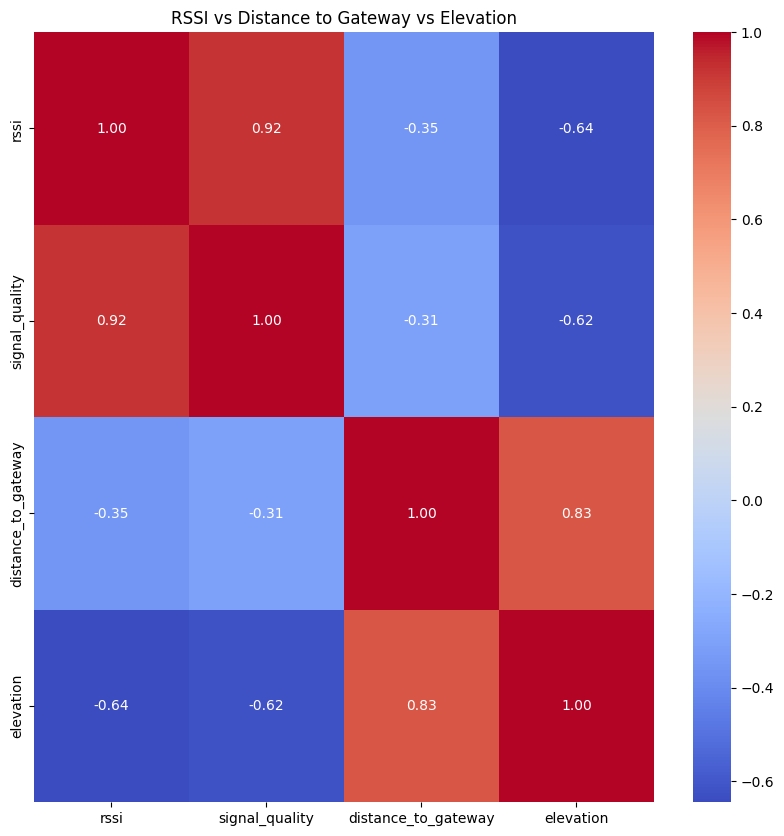

In [150]:
plt.figure(figsize=(10, 10))
plt.title('RSSI vs Distance to Gateway vs Elevation')

X = dataframe[['rssi', 'signal_quality', 'distance_to_gateway', 'elevation']]
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Porcentagem de Sinais com base na classificação da qualidade

Samples with good signal: 183
Samples with medium signal: 172
Samples with bad signal: 156


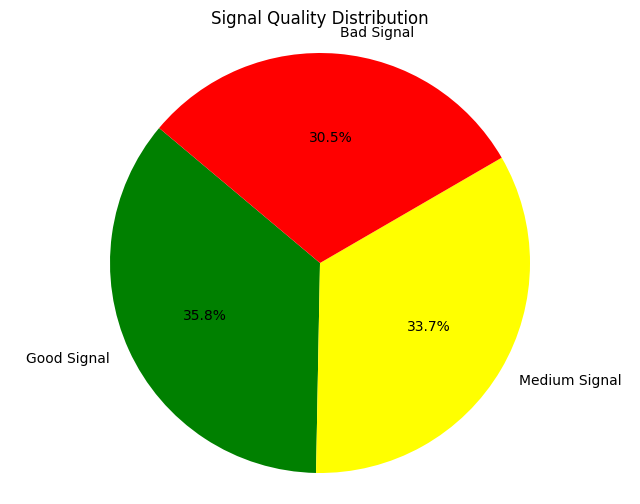

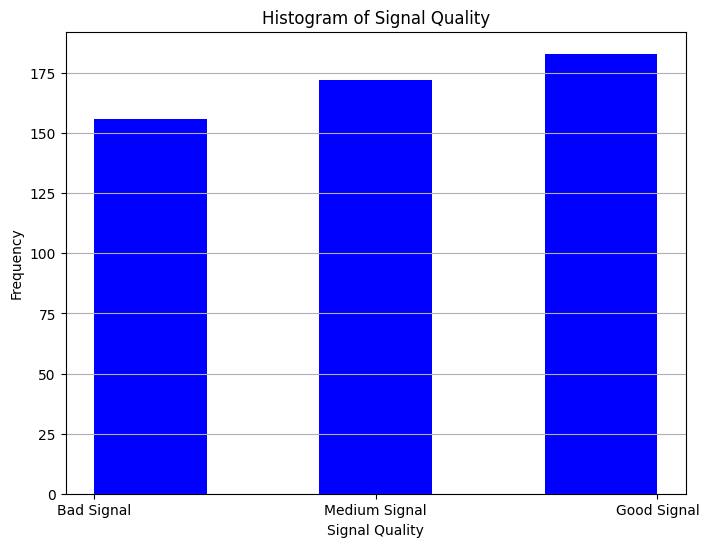

In [151]:
count_good_signal = (dataframe['signal_quality'] == good_signal_value).sum()
count_medium_signal = (dataframe['signal_quality'] == medium_signal_value).sum()
count_bad_signal = (dataframe['signal_quality'] == bad_signal_value).sum()

print(f"Samples with good signal: {count_good_signal}")
print(f"Samples with medium signal: {count_medium_signal}")
print(f"Samples with bad signal: {count_bad_signal}")

labels = ['Good Signal', 'Medium Signal', 'Bad Signal']
sizes = [count_good_signal, count_medium_signal, count_bad_signal]
colors = ['green', 'yellow', 'red']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Signal Quality Distribution')
plt.axis('equal')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(dataframe['signal_quality'], bins=5, color='blue', alpha=1)
plt.title('Histogram of Signal Quality')
plt.xlabel('Signal Quality')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Bad Signal', 'Medium Signal', 'Good Signal'])
plt.grid(axis='y', alpha=1.0)
plt.show()

# Balancing Classes

Used methods:
- SMOTE
- Borderline-SMOTE

Resampling completed using SMOTE.
Resampled dataset size: (549, 4)
Resampling completed using Borderline-SMOTE.
Resampled dataset size: (549, 4)


/var/folders/pm/2gprwlj544b4bg6qdxxvwbh00000gn/T/ipykernel_10647/1010139909.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='viridis')


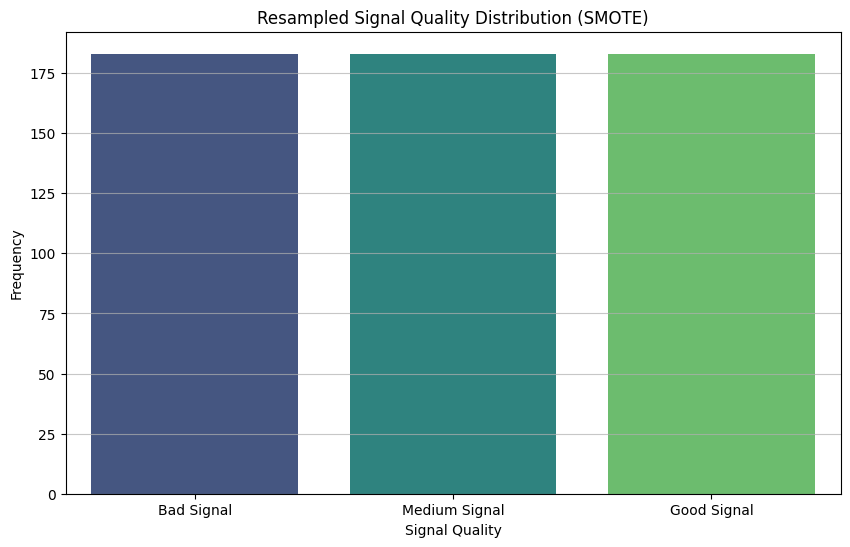

/var/folders/pm/2gprwlj544b4bg6qdxxvwbh00000gn/T/ipykernel_10647/1010139909.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled_bl, palette='viridis')


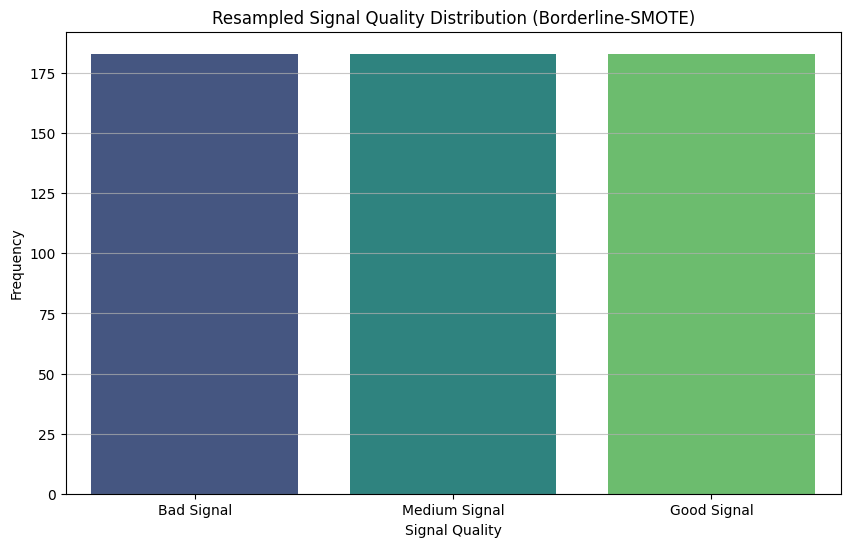

In [152]:
X = dataframe[['latitude', 'longitude', 'rssi', 'elevation']]
y = dataframe['signal_quality']

sampler = SMOTE(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

print("Resampling completed using SMOTE.")
print("Resampled dataset size:", X_resampled.shape)

sampler = BorderlineSMOTE(random_state=42)
X_resampled_bl, y_resampled_bl = sampler.fit_resample(X, y)

print("Resampling completed using Borderline-SMOTE.")
print("Resampled dataset size:", X_resampled_bl.shape)

plt.figure(figsize=(10, 6))
plt.title('Resampled Signal Quality Distribution (SMOTE)')
sns.countplot(x=y_resampled, palette='viridis')
plt.xlabel('Signal Quality')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Bad Signal', 'Medium Signal', 'Good Signal'])
plt.grid(axis='y', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
plt.title('Resampled Signal Quality Distribution (Borderline-SMOTE)')
sns.countplot(x=y_resampled_bl, palette='viridis')
plt.xlabel('Signal Quality')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Bad Signal', 'Medium Signal', 'Good Signal'])
plt.grid(axis='y', alpha=0.7)
plt.show()

# Smote tem o melhor balanceamento

Fazendo o balancenamento do dataframe com o SMOTE

Dataframe balanceado com SMOTE.
Novo tamanho do dataframe: (549, 4)
Distribuição das classes após SMOTE:
 signal_quality
2    183
1    183
0    183
Name: count, dtype: int64


/var/folders/pm/2gprwlj544b4bg6qdxxvwbh00000gn/T/ipykernel_10647/3300663438.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='signal_quality', data=balanced_df, palette='viridis')


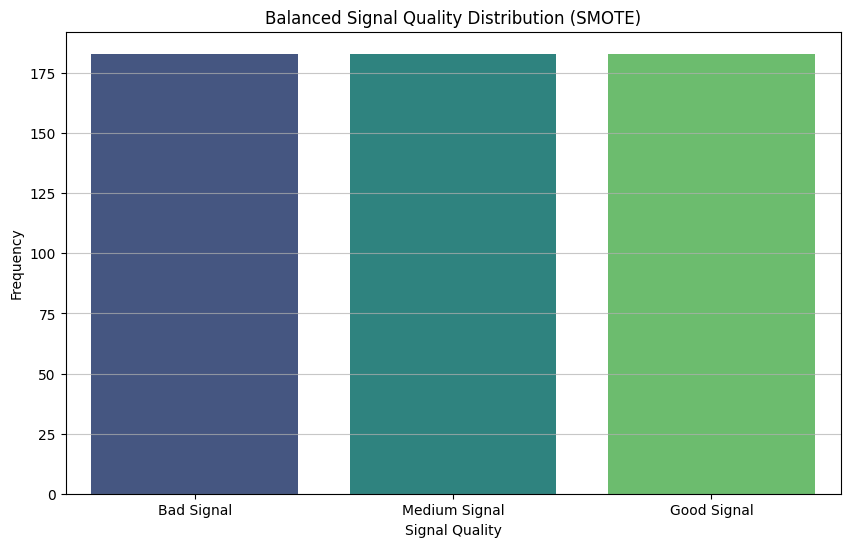

In [153]:
smote_sampler = SMOTE(random_state=42)
X_smote, y_smote = smote_sampler.fit_resample(X, y)

print("Dataframe balanceado com SMOTE.")
print("Novo tamanho do dataframe:", X_smote.shape)
print("Distribuição das classes após SMOTE:\n", y_smote.value_counts())

# Save the balanced dataset
balanced_df = pd.DataFrame(X_smote, columns=X.columns)
balanced_df['signal_quality'] = y_smote

plt.figure(figsize=(10, 6))
plt.title('Balanced Signal Quality Distribution (SMOTE)')
sns.countplot(x='signal_quality', data=balanced_df, palette='viridis')
plt.xlabel('Signal Quality')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Bad Signal', 'Medium Signal', 'Good Signal'])
plt.grid(axis='y', alpha=0.7)
plt.show()

# Plotando os pontos com o dataset balanceado

In [154]:
folium_map_balanced = f.Map(location=[dataframe['latitude'].mean(), dataframe['longitude'].mean()], zoom_start=15)

for _, row in balanced_df.iterrows():
    color = 'green' if row['signal_quality'] == 2 else ('yellow' if row['signal_quality'] == 1 else 'red')
    f.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        popup=f"RSSI: {row['rssi']}, Quality: {row['signal_quality']}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(folium_map_balanced)

folium_map_balanced

# Separando os dados em treino e teste

In [155]:
X = balanced_df[['latitude', 'longitude', 'elevation']]
y = balanced_df['signal_quality']

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Definindo os pipelines e classificadores

In [156]:
pipelines = {
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'SVC': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ])
}

print("Pipelines and classifiers defined.")

Pipelines and classifiers defined.


# Definindo os espaços de busca (param grids)

In [157]:
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
}

print("Pipelines and parameter grids defined for model training.")

Pipelines and parameter grids defined for model training.


# Busca randômica com validação cruzada

In [159]:
best_models = {}

for name in pipelines:
    search = RandomizedSearchCV(
        estimator=pipelines[name],
        param_distributions=param_grids[name],
        n_iter=20,
        scoring='f1_weighted',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best model for {name} found with parameters: {search.best_params_}")

print("Model training completed with hyperparameter tuning.")

22313.99s - Error patching args (debugger not attached to subprocess).
Traceback (most recent call last):
  File "/Users/bitcoder/Documents/Projects/lora-coverage-map/.venv/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 541, in patch_args
    new_args.append(_get_python_c_args(host, port, code, unquoted_args, SetupHolder.setup))
                    ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bitcoder/Documents/Projects/lora-coverage-map/.venv/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 193, in _get_python_c_args
    if "__future__" in code:
       ^^^^^^^^^^^^^^^^^^^^
TypeError: a bytes-like object is required, not 'str'
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will procee

Best model for RandomForest found with parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__max_depth': 30}
Best model for SVC found with parameters: {'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__C': 10}
Best model for KNN found with parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 5}
Model training completed with hyperparameter tuning.


/Users/bitcoder/Documents/Projects/lora-coverage-map/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bitcoder/Documents/Projects/lora-coverage-map/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Avaliação final no conjunto de testes

In [161]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Classification report for {name}:\n", classification_report(y_test, y_pred, target_names=['Bad Signal', 'Medium Signal', 'Good Signal']))
    print(f"Model {name} evaluation completed.")

best_model = max(best_models, key=lambda k: best_models[k].score(X_test, y_test))
print(f"The best model is: {best_model} with score: {best_models[best_model].score(X_test, y_test)}")

Classification report for RandomForest:
                precision    recall  f1-score   support

   Bad Signal       1.00      1.00      1.00        25
Medium Signal       1.00      1.00      1.00        38
  Good Signal       1.00      1.00      1.00        47

     accuracy                           1.00       110
    macro avg       1.00      1.00      1.00       110
 weighted avg       1.00      1.00      1.00       110

Model RandomForest evaluation completed.
Classification report for SVC:
                precision    recall  f1-score   support

   Bad Signal       1.00      1.00      1.00        25
Medium Signal       1.00      1.00      1.00        38
  Good Signal       1.00      1.00      1.00        47

     accuracy                           1.00       110
    macro avg       1.00      1.00      1.00       110
 weighted avg       1.00      1.00      1.00       110

Model SVC evaluation completed.
Classification report for KNN:
                precision    recall  f1-score  

# Plotando mapa hexagonal com novos pontos